# Exercise 11-12: Visual Odometry

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

In [9]:
K = np.loadtxt('Glyp/K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

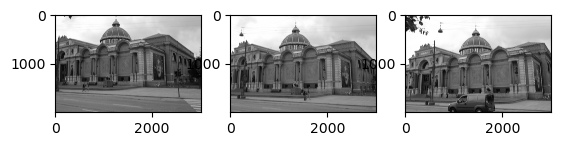

(2000, 3008, 3) (2000, 3008, 3) (2000, 3008, 3)


In [13]:
im0 = cv2.imread('Glyp/sequence/000001.png')[:,:,::-1]
im1 = cv2.imread('Glyp/sequence/000002.png')[:,:,::-1]
im2 = cv2.imread('Glyp/sequence/000003.png')[:,:,::-1]

fig, ax = plt.subplots(1,3)
ax[0].imshow(im0)
ax[1].imshow(im1)
ax[2].imshow(im2)
plt.show()

print(im0.shape, im1.shape, im2.shape)

### Exercise 11.1

In [237]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp0, des0 = sift.detectAndCompute(im0,None)
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)


In [238]:
len(kp0) # tuple

20735

In [239]:
des0.shape # np array

(20735, 128)

In [99]:
# For speed reasons, you can limit the number of SIFT features to 2000
n = 2000
kp0 = kp0[:n]
kp1 = kp1[:n]
kp2 = kp2[:n]
des0 = des0[:n,:]
des1 = des1[:n,:]
des2 = des2[:n,:]

In [240]:
# Convert the features to numpy arrays of 2D points
kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])

In [241]:
kp0

array([[2.26103210e+00, 8.43691772e+02],
       [2.26103210e+00, 8.43691772e+02],
       [2.83079910e+00, 8.10171448e+02],
       ...,
       [3.00478345e+03, 1.74719055e+03],
       [3.00493164e+03, 8.40037170e+02],
       [3.00506055e+03, 9.97906250e+02]])

In [242]:
# Match the SIFT features between im0 and im1 (matches01), 
# and between im1 and im2 (matches12).

bf = cv2.BFMatcher_create(crossCheck=True) # cross checking
matches01 = bf.knnMatch(des0, des1, k=1)
matches12 = bf.knnMatch(des1, des2, k=1)

In [246]:
# get non empty tuples
good_matches01 = []  
for m in matches01:
    if m:
        good_matches01.append([m[0]])
        
good_matches12 = []  
for m in matches12:
    if m:
        good_matches12.append([m[0]])

In [249]:
# Sort them in the order of their distance
good_matches01 = sorted(good_matches01, key = lambda x:x[0].distance)
good_matches12 = sorted(good_matches12, key = lambda x:x[0].distance)

In [250]:
# Convert the matches to numpy arrays of the indices
matches01 = np.array([(m[0].queryIdx, m[0].trainIdx) for m in good_matches01])
matches12 = np.array([(m[0].queryIdx, m[0].trainIdx) for m in good_matches12])

In [260]:
# keep 2000 best
matches01 = matches01[:2000,:]
matches12 = matches12[:2000,:]

In [261]:
matches01.shape

(2000, 2)

In [262]:
matches01

array([[   20,     9],
       [16408,    22],
       [18781,    40],
       ...,
       [ 7222,  8385],
       [ 6910,  8392],
       [ 7232,  8403]])

### Exercise 11.2

In [263]:
# Find coordinates
pts01_im0 = kp0[matches01[:,0]]
pts01_im1 = kp1[matches01[:,1]] 

# Estimate the essential matrix between im0 and im1 with RANSAC.
K01,mask = cv2.findEssentialMat(pts01_im0, pts01_im1)

# Decompose the essential matrix and find the correct relative pose (R1, t1)
R1,t1 = cv2.recoverPose(K01,pts01_im0,pts01_im1)[1:3]

In [264]:
K01, R1,t1

(array([[-2.17980655e-06, -9.76351545e-05, -4.48363773e-01],
        [ 1.19751646e-04, -1.72745241e-05,  5.46781415e-01],
        [ 4.60699664e-01, -5.36428752e-01, -2.43999642e-05]]),
 array([[ 9.99740648e-01,  2.27735958e-02, -9.81958180e-06],
        [-2.27735954e-02,  9.99740647e-01,  3.65726026e-05],
        [ 1.06499247e-05, -3.63394903e-05,  9.99999999e-01]]),
 array([[ 7.73265695e-01],
        [ 6.34082124e-01],
        [-1.61160978e-04]]))

In [265]:
print(mask.shape) # The mask returned by cv2.recoverPose indicates which of the matches 
# are inliers (1), that lie in front of both cameras
print('nb of inliers : ', np.sum(mask))

(2000, 1)
nb of inliers :  1082


In [266]:
# Remove the matches that are not inliers from matches01, so that only contains
# the inliers.
matches01_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches01_inliers.append(matches01[i,:])
matches01_inliers = np.array(matches01_inliers)

In [267]:
matches01_inliers.shape

(1082, 2)

### Exercise 11.3

In [268]:
# Use matches01 and matches12 and find the subset of matches such that we can 
# match features all the way from image 0 to image 2. In other words, create three 
# lists such that points0[i], points1[i], and points2[i] are the 2D locations of 
# the same point in the corresponding images.

_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)
matches01 = matches01[idx01]
matches12 = matches12[idx12]

points0 = kp0[matches01[:,0]]
points1 = kp1[matches01[:,1]] 
points2 = kp2[matches12[:,1]] 

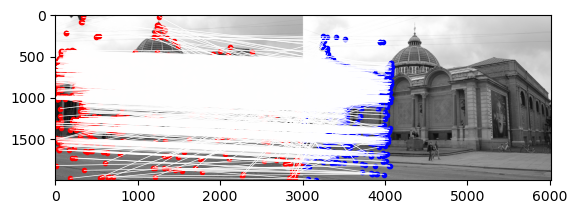

In [269]:
r1,c1,d1 = im0.shape
r2,c2,d2 = im1.shape
n_row = np.maximum(r1, r2)
n_col = c1 + c2
im_comp = np.zeros((n_row,n_col,3))
im_comp[:r1,:c1,:d1] = im0
im_comp[:r2,c1:(c1+c2),:d2] = im1
im_comp = im_comp.astype('uint8')

# show every sift
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(points0[:,0],points0[:,1],'.r')
ax.plot(points1[:,0]+c1,points1[:,1],'.b')
ax.plot(np.c_[points0[:,0],points1[:,0]+c1].T,np.c_[points0[:,1],points1[:,1]].T,'w',linewidth = 0.5)

plt.show()

In [270]:
points0[23] == kp0[matches01[23,0]]

array([ True,  True])

In [271]:
matches01[:,1] == matches12[:,0]

array([ True,  True,  True, ...,  True,  True,  True])

In [272]:
points0.shape

(2000, 2)

### Exercise 11.4

In [273]:
def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

def triangulate(qs, Ps):
    """
    qs : list of n pixel coordinates (q1, q2,. . . , qn)
    Ps : list of n projection matrices (P1, P2, . . . , Pn)
    return the triangulation of the point in 3D using the linear algorithm.
    """
    n = len(Ps)
    B = np.zeros((2*n,4))
    for i in range(n):
        B[i*2,:] = Ps[i][2,:] * qs[i][0] - Ps[i][0,:]
        B[i*2+1,:] = Ps[i][2,:] * qs[i][1] - Ps[i][1,:]
        
    Q = np.linalg.svd(B)[2][-1,:]
    Q.shape += (1,)
    return PiInv(Q)

In [274]:
## triangulate

# Cam1
R0 = np.identity(3)
t0 = np.array([[0], [0], [0]])
P0 = K @ ( np.hstack((R0,t0)) )

# Cam2
P1 = K @ ( np.hstack((R1,t1)) )

Q = np.zeros((3,points0.shape[0]))
for i in range(points0.shape[0]):
    q0 = points0[i,:]
    q1 = points1[i,:] 
    q0.shape += (1,)
    q1.shape += (1,)
    q3D = triangulate([q0,q1], [P0,P1])
    Q[:,i] = q3D[:,0]

In [305]:
Q.shape

(3, 2000)

In [276]:
# Using the 2D positions in image 2, estimate the pose
# of image 2 with RANSAC.
retval, rvec, tvec, inliers = cv2.solvePnPRansac(Q.T, points2, K, np.zeros(5))

rvec = cv2.Rodrigues(rvec)[0]

In [281]:
retval

True

In [304]:
inliers.shape

(1214, 1)

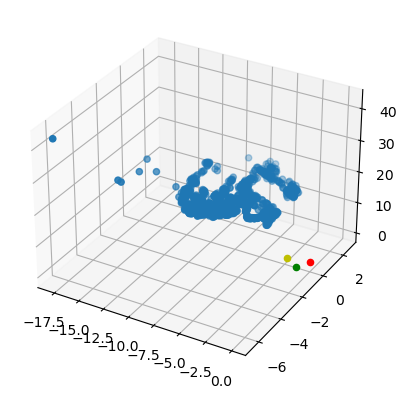

In [316]:
QT = Q.T[inliers.flatten()]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(QT[:,0], QT[:,1], QT[:,2])
ax.scatter(0, 0, 0, c='r')

C1 = -R1.T@t1
C2 = -rvec.T@tvec
ax.scatter(C1[0], C1[1], C1[2], c='g')
ax.scatter(C2[0], C2[1], C2[2], c='y')

In [317]:
# Looks correct !

## Expand your algorithm